In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import json
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from preprocess_utensils import get_gray_image
from dataloader import normalize_image, DAVIS_test, Balltest
from polygon import SoftPolygon, RasLoss

In [2]:
test_set = Balltest("ellipse/uniform_samples_80.json")

In [3]:
img, sgm, bou = test_set[0]
sgm[sgm > 0] = 1
torch.Tensor(sgm).int().unique()

tensor([0, 1], dtype=torch.int32)

In [4]:
class CircleRaw(Dataset):
    def __init__(self) -> None:
        self.json_path = "ellipse/uniform_samples_80.json"
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.data = json.load(open(self.json_path, "r"))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, bou = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        sgm = get_gray_image(img_path)
        sgm[sgm > 0] = 1
        sgm = torch.Tensor(sgm)
        bou = np.array(bou).astype(np.int32)
        bou = torch.Tensor(bou).int()
        return img, sgm, bou


In [5]:
raw_set = CircleRaw()
img, sgm, bou = raw_set[0]
sgm.unique()

tensor([0., 1.])

In [6]:
class CircleDataset(Dataset):
    def __init__(self) -> None:
        self.raw_dataset = CircleRaw()
        self.first_data = self.raw_dataset[0]
        self.data = []
        for i in range(len(self.raw_dataset) - 1):
            self.data.append(
                (
                    self.raw_dataset[i],
                    self.raw_dataset[i + 1],
                ),
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        pre_data, cur_data = self.data[idx]
        fir_img, fir_sgm, fir_bou = self.first_data
        pre_img, pre_sgm, pre_bou = pre_data
        cur_img, cur_sgm, cur_bou = cur_data
        pre_idx = idx
        return (
            pre_idx,
            fir_img,
            fir_sgm,
            fir_bou,
            pre_img,
            pre_sgm,
            pre_bou,
            cur_img,
            cur_sgm,
            cur_bou,
        )

In [7]:
dataset = CircleDataset()
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset)

19

In [8]:
(
    pre_idx,
    fir_img,
    fir_sgm,
    fir_bou,
    pre_img,
    pre_sgm,
    pre_bou,
    cur_img,
    cur_sgm,
    cur_bou,
) = next(iter(dataloader))
pre_idx

tensor([13])

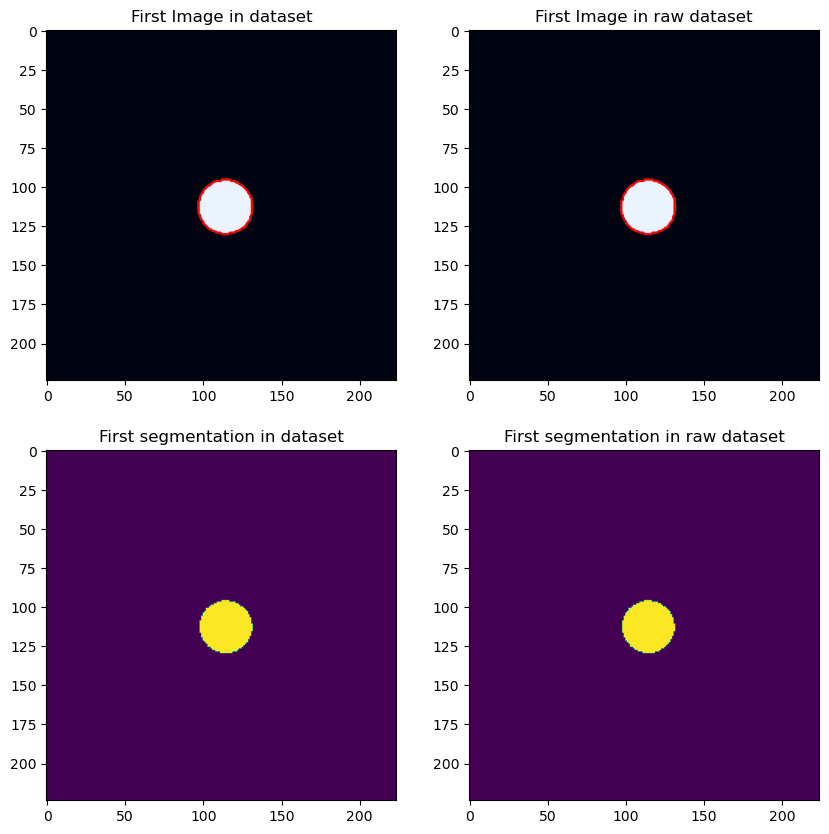

In [9]:
index = 0
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(normalize_image(fir_img[index]).permute(1, 2, 0))
plt.plot(fir_bou[index][:, 0], fir_bou[index][:, 1], "r")
plt.title("First Image in dataset")
plt.subplot(2, 2, 2)
plt.imshow(normalize_image(raw_set[0][0]).permute(1, 2, 0))
plt.plot(raw_set[0][2][:, 0], raw_set[0][2][:, 1], "r")
plt.title("First Image in raw dataset")
plt.subplot(2, 2, 3)
plt.imshow(fir_sgm[index])
plt.title("First segmentation in dataset")
plt.subplot(2, 2, 4)
plt.imshow(raw_set[0][1])
plt.title("First segmentation in raw dataset")
plt.show()

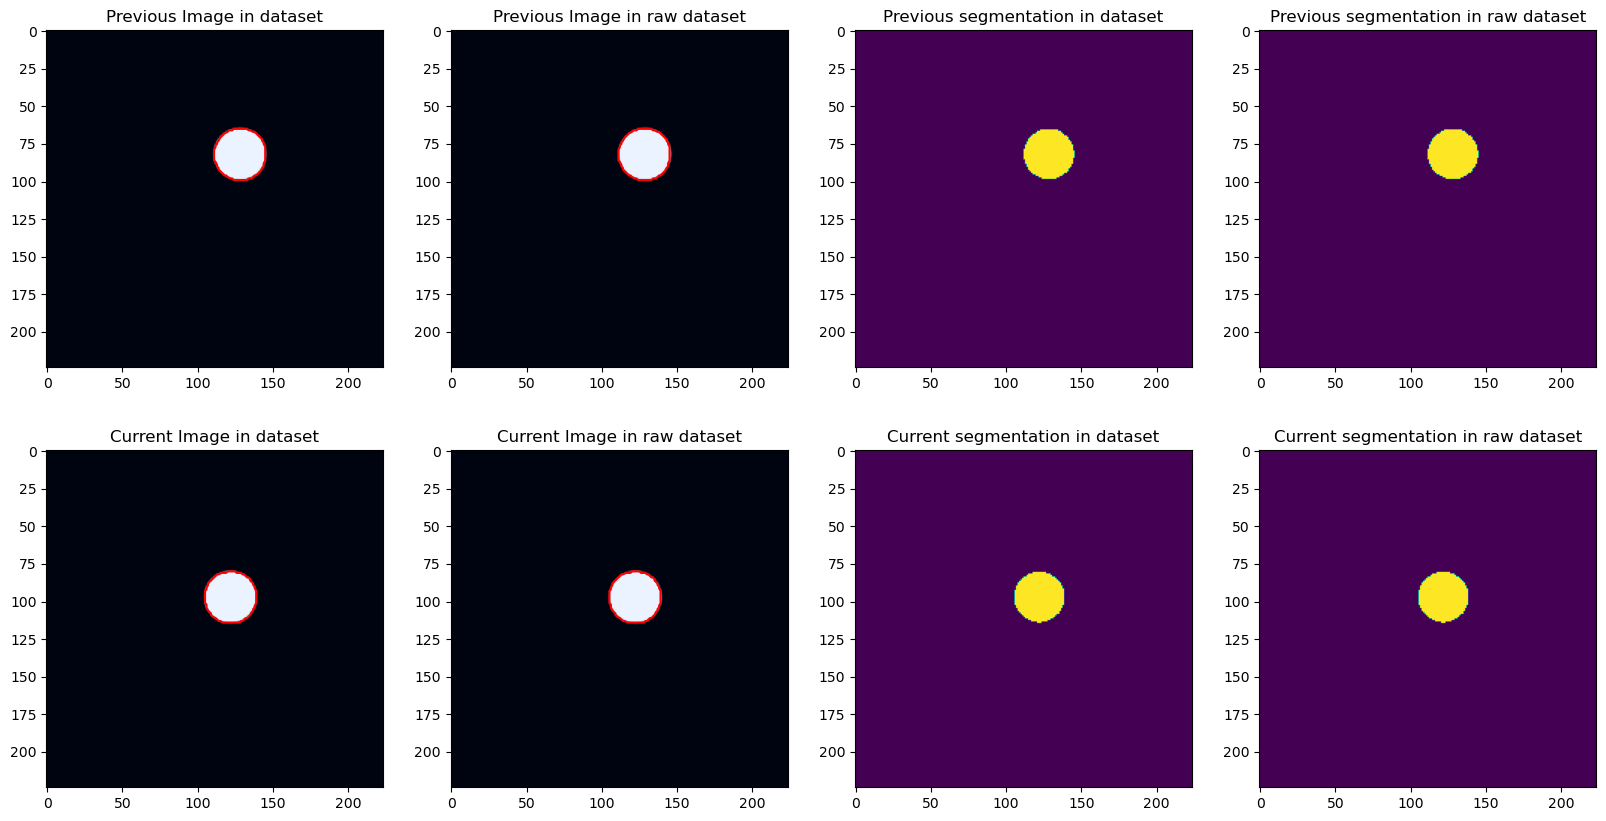

In [10]:
index = 0
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.imshow(normalize_image(pre_img[index]).permute(1, 2, 0))
plt.plot(pre_bou[index][:, 0], pre_bou[index][:, 1], "r")
plt.title("Previous Image in dataset")
plt.subplot(2, 4, 2)
plt.imshow(normalize_image(raw_set[pre_idx.item()][0]).permute(1, 2, 0))
plt.plot(
    raw_set[pre_idx.item()][2][:, 0],
    raw_set[pre_idx.item()][2][:, 1],
    "r",
)
plt.title("Previous Image in raw dataset")
plt.subplot(2, 4, 3)
plt.imshow(pre_sgm[index])
plt.title("Previous segmentation in dataset")
plt.subplot(2, 4, 4)
plt.imshow(raw_set[pre_idx.item()][1])
plt.title("Previous segmentation in raw dataset")
plt.subplot(2, 4, 5)
plt.imshow(normalize_image(cur_img[index]).permute(1, 2, 0))
plt.plot(cur_bou[index][:, 0], cur_bou[index][:, 1], "r")
plt.title("Current Image in dataset")
plt.subplot(2, 4, 6)
plt.imshow(
    normalize_image(raw_set[pre_idx.item() + 1][0]).permute(1, 2, 0),
)
plt.plot(
    raw_set[pre_idx.item() + 1][2][:, 0],
    raw_set[pre_idx.item() + 1][2][:, 1],
    "r",
)
plt.title("Current Image in raw dataset")
plt.subplot(2, 4, 7)
plt.imshow(cur_sgm[index])
plt.title("Current segmentation in dataset")
plt.subplot(2, 4, 8)
plt.imshow(raw_set[pre_idx.item() + 1][1])
plt.title("Current segmentation in raw dataset")
plt.show()

In [11]:
softpolygon = SoftPolygon(0.1)
ras_polygon = softpolygon(cur_bou.float().cuda(), 224, 224)

In [12]:
ras_polygon.max(), ras_polygon.min()

(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))

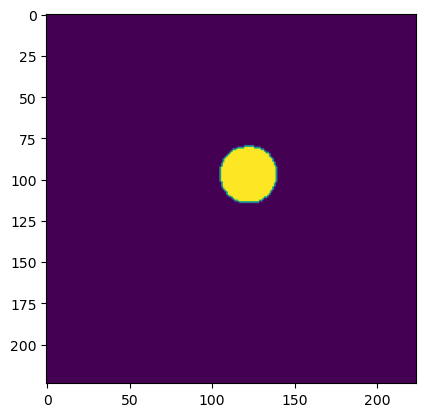

In [13]:
plt.imshow(ras_polygon[0].detach().cpu())

In [14]:
ras_loss = RasLoss()

In [30]:
tmp = pre_bou.cuda() + 20.
tmp.requires_grad = True
ras_loss(tmp, pre_sgm.cuda())

tensor(0.9183, device='cuda:0', grad_fn=<RsubBackward1>)